In [1]:
from DLtools.Data_preprocess import series_to_supervised,load_data,preprocess

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
r='data/instant_data/rain_small.csv'
w='data/instant_data/water_small.csv'
rw = load_data(r,w)
df =rw.df.resample('d').mean()

DataFrame shape: (465169, 35)


# Preprocessing

In [3]:
X_in = df['CPY015_w']['2013-01-01':'2015-01-01'].interpolate(limit=7)
X_in = X_in.astype('float32')

In [4]:
scaler_target = MinMaxScaler()
X_in = scaler_target.fit_transform(X_in.values.reshape(-1,1))
print(np.min(X_in),np.max(X_in))

0.0 1.0


In [5]:
LOOKBACK=7

prep = preprocess(X_in,Y_column=None,n_timelag=LOOKBACK,n_feature=1,scale_ornot=False)
train_X, train_Y = prep.train_X,prep.train_Y
val_X,val_y = prep.val_X,prep.val_y
test_X,test_y =prep.test_X,prep.test_Y

X,Y = prep.train_val_X,prep.train_val_Y

#ori_trainX,ori_trianY = prep.ori_trainX,prep.ori_trainY

================================================== preview Supervised ==================================================
    var1(t-7)  var1(t-6)  var1(t-5)  var1(t-4)  var1(t-3)  var1(t-2)  \
7    0.707035   0.621722   0.592684   0.566552   0.565485   0.440533   
8    0.621722   0.592684   0.566552   0.565485   0.440533   0.516498   
9    0.592684   0.566552   0.565485   0.440533   0.516498   0.466665   
10   0.566552   0.565485   0.440533   0.516498   0.466665   0.542813   
11   0.565485   0.440533   0.516498   0.466665   0.542813   0.625513   

    var1(t-1)   var1(t)  
7    0.516498  0.466665  
8    0.466665  0.542813  
9    0.542813  0.625513  
10   0.625513  0.649988  
11   0.649988  0.725089  
     var1(t-7)  var1(t-6)  var1(t-5)  var1(t-4)  var1(t-3)  var1(t-2)  \
726   0.592095   0.651620   0.665001   0.540822   0.576913   0.632212   
727   0.651620   0.665001   0.540822   0.576913   0.632212   0.599727   
728   0.665001   0.540822   0.576913   0.632212   0.599727   0.530870  

# LSTM

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.callbacks import EarlyStopping


In [7]:
EPOCH = 100
BATCH = 7
VALIDATION = (val_X,val_y)

callback_early_stopping = EarlyStopping(monitor='val_loss',patience=5, verbose=2)
callbacks = [callback_early_stopping]

In [8]:
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(LOOKBACK, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [9]:
history = model.fit(train_X, train_Y, epochs=EPOCH, batch_size=BATCH, verbose=1,shuffle=False,validation_data=VALIDATION,callbacks=callbacks)

Epoch 1/100
51/51 [==============================] - 1s 17ms/step - loss: 0.0613 - val_loss: 0.0062
Epoch 2/100
51/51 [==============================] - 1s 11ms/step - loss: 0.0057 - val_loss: 0.0060
Epoch 3/100
51/51 [==============================] - 1s 12ms/step - loss: 0.0054 - val_loss: 0.0061
Epoch 4/100
51/51 [==============================] - 1s 12ms/step - loss: 0.0053 - val_loss: 0.0062
Epoch 5/100
51/51 [==============================] - 1s 10ms/step - loss: 0.0053 - val_loss: 0.0063
Epoch 6/100
51/51 [==============================] - 1s 13ms/step - loss: 0.0052 - val_loss: 0.0065
Epoch 7/100
51/51 [==============================] - 1s 11ms/step - loss: 0.0052 - val_loss: 0.0066
Epoch 00007: early stopping


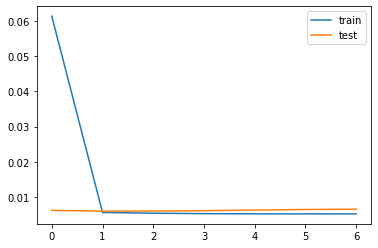

In [10]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [11]:
# generate predictions for training
trainPredict = model.predict(X)
testPredict = model.predict(test_X)

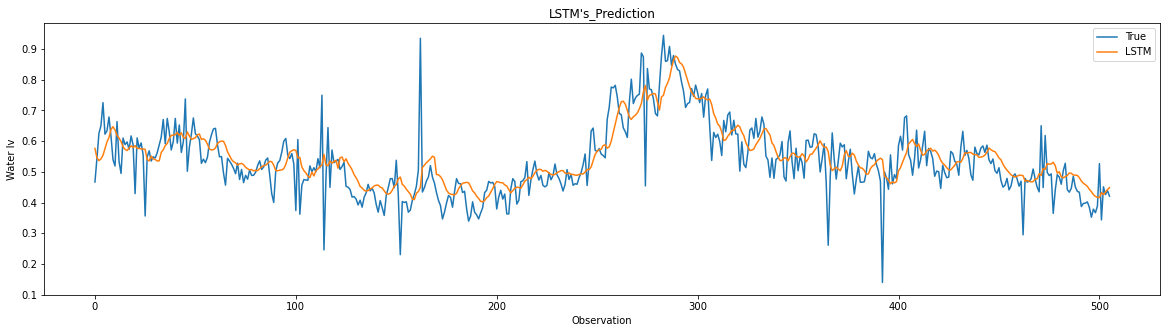

In [12]:
#plot the result from model prediction

result_test = np.squeeze(trainPredict)
true_data = np.squeeze(Y)

plt.figure(figsize=(20,5))
plt.plot(true_data, label='True')
plt.plot(result_test, label='LSTM')
plt.title("LSTM's_Prediction")
plt.xlabel('Observation')
plt.ylabel('Water lv')

plt.legend()
plt.show()

In [13]:
# Estimate model performance
trainScore = model.evaluate(X,Y, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(test_X,test_y, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 0.01 MSE (0.07 RMSE)
Test Score: 0.01 MSE (0.10 RMSE)


In [14]:
import hydroeval

trainScore = hydroeval.nse(trainPredict,Y)
print('Train Score: %.2f NSE ' % (trainScore))
testScore = hydroeval.nse(testPredict,test_y)
print('Test Score: %.2f NSE ' % (testScore))

Train Score: 0.59 NSE 
Test Score: 0.30 NSE 


In [15]:
scale_trainPredict = scaler_target.inverse_transform(trainPredict)
scale_testPredict = scaler_target.inverse_transform(testPredict)
scale_X_in = scaler_target.inverse_transform(X_in)

print(np.min(scale_X_in),np.max(scale_X_in))
print(np.min(scale_trainPredict),np.max(scale_trainPredict))
print(np.min(scale_testPredict),np.max(scale_testPredict))

-0.5368421 1.35
0.22217469 1.1173238
0.12804759 0.63625884


In [16]:
# # # shift train predictions for plotting
# trainPredictPlot = np.empty_like(X_in)
# trainPredictPlot[:] = np.nan
# trainPredictPlot = trainPredictPlot.reshape(-1,1)
# trainPredictPlot[LOOKBACK:len(trainPredict)+LOOKBACK,:] = trainPredict
# # # shift test predictions for plotting
# # testPredictPlot = np.empty_like(X_in)
# # testPredictPlot[:] = np.nan
# # testPredictPlot = testPredictPlot.reshape(-1,1)
# # testPredictPlot[len(trainPredict)+(LOOKBACK*2)+1:len(X_in)-1, :] = testPredict
# # plot baseline and predictions
# plt.figure(figsize=(20,5))
# plt.plot(X_in[LOOKBACK:-LOOKBACK])
# plt.plot(trainPredictPlot)
# #plt.plot(testPredictPlot)
# plt.show()